### **Introduction:**

Optical coherence tomography (OCT) is an imaging technique that uses coherent light to capture high resolution images of biological tissues. OCT is heavily used by ophthalmologists to obtain high resolution images of the eye retina.

OCT is an emerging biomedical imaging technology that offers non-invasive real-time, high-resolution imaging of highly scattering tissues. It is widely used by ophthalmologist to perform diagnostic imaging on the structure of the anterior eye and the retina.

## **Project Goal:**

In this project, we will classify the OCT scans to classify the retinal disease. We can either implement models from sctarch or use pretrained models and fine-tune it for our application.

I am going to use VGG16 in this project. VGG network is using only 3 x 3 convolutional layers stacked on top of each other in increasing depth. Reducing the volume size is handled by max pooling. At the end, two fully connected layers, each with 4,096 nodes, are then followed by a softmax layer. Max pooling is performed over a 2 x 2 pixel window, with a stride of 2. ReLU activation is used in each of the hidden layers. The 16-layered architecture VGG-16 is shown in the following diagram.

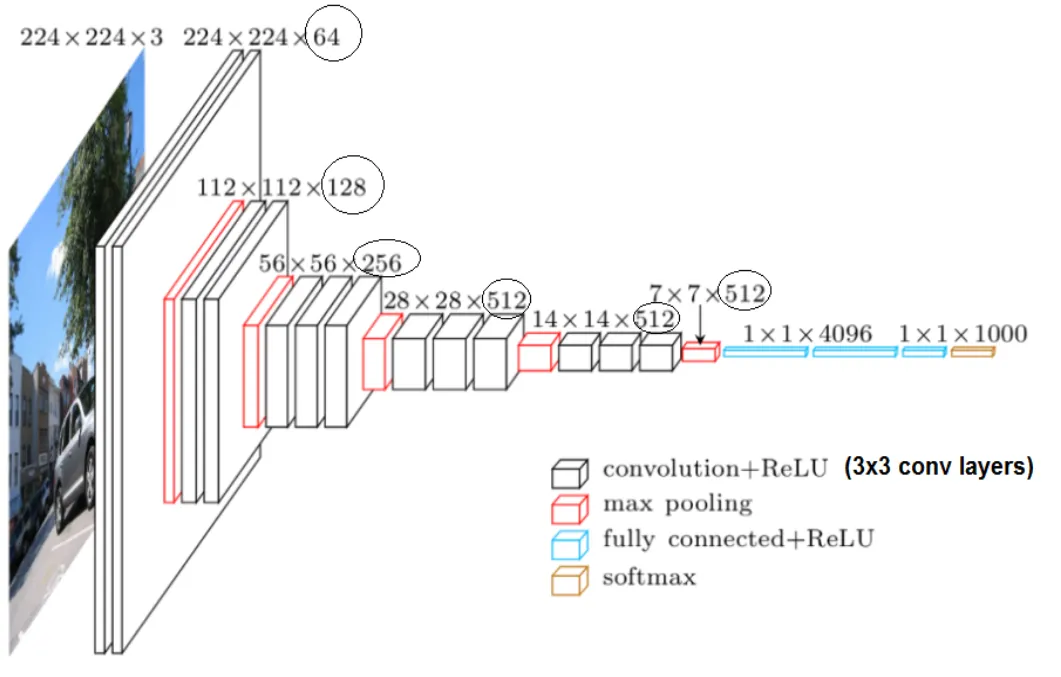



### About dataset:

There are various ways the retina can become damaged. Here are three different types of retinal damage:

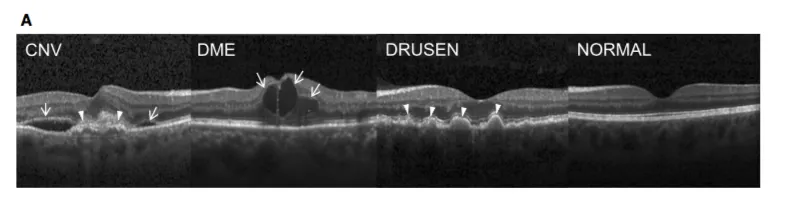

**1. CNV (Choroidal Neovascularization):**

CNV is like the growth of weird blood vessels in the back of your eye. These blood vessels are not normal and can cause damage to your eye, making it hard to see.

**2. DME (Diabetic Macular Edema):**

DME is when the middle part of your eye swells up because you have diabetes. This swelling can mess up your vision and make things look blurry. It's a common eye problem for people with diabetes.

**3. Drusen:**

Drusen are like little yellow or white spots that can show up under your eye's seeing part. They're often a sign that your eyes might have a problem called age-related macular degeneration.

**Normal**

Normal vision occurs when light is focused directly on the retina rather than in front or behind it. A person with normal vision can see objects clearly near and faraway.



** The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).

Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

Dataset link: https://www.kaggle.com/datasets/paultimothymooney/kermany2018

### Import libraries

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
#from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
#from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

### Import dataset from Kaggle

In [ ]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 64

In [ ]:
train_data_dir = '../input/kermany2018/oct2017/OCT2017 /train'
validation_data_dir='../input/kermany2018/oct2017/OCT2017 /test'

In [ ]:
import os
cnv = os.listdir('../input/kermany2018/oct2017/OCT2017 /train/CNV')
dme = os.listdir('../input/kermany2018/oct2017/OCT2017 /train/DME')
drusen = os.listdir('../input/kermany2018/oct2017/OCT2017 /train/DRUSEN')
normal = os.listdir('../input/kermany2018/oct2017/OCT2017 /train/NORMAL')

# Count the number of image files (e.g., assume they have '.jpg' or '.png' extensions)
image_files1 = [file for file in cnv if file.endswith('.jpeg')]
image_files2 = [file for file in dme if file.endswith('.jpeg')]
image_files3 = [file for file in drusen if file.endswith('.jpeg')]
image_files4 = [file for file in normal if file.endswith('.jpeg')]
# Get the total number of image files
num_images = len(image_files1)+len(image_files2)+len(image_files3)+len(image_files4)

print(f"Total number of pictures in the 'train' folder: {num_images},\n"
      f"CNV: {len(image_files1)}, DME:{len(image_files2)}, DRUSEN:{len(image_files3)}, Normal:{len(image_files4)}")



### Image Augmentation

The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images.

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

## **Building VGG model**

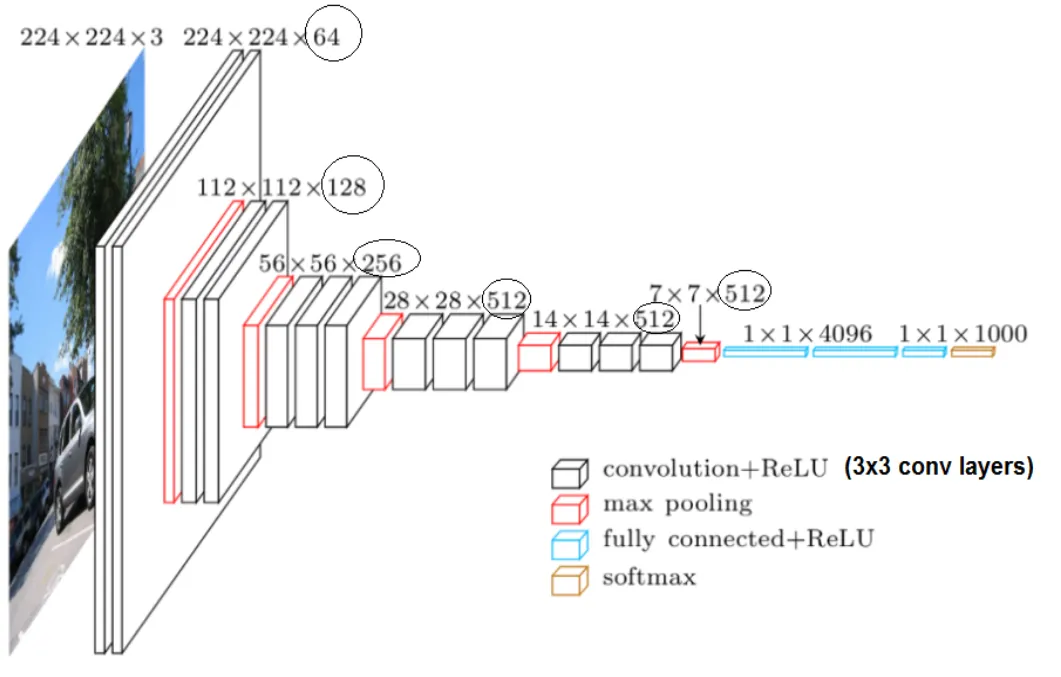

In [ ]:
def vgg():
    model = Sequential([

    # 1st CONV-ReLU Layer
    Conv2D(64, (3, 3), activation="relu",padding = 'same', input_shape = (img_rows, img_cols, 3)),
    BatchNormalization(),

    # 2nd CONV-ReLU Layer
    Conv2D(64, (3, 3), activation="relu", padding = "same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 3rd set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation="relu",padding="same"),
    BatchNormalization(),

    # 4th Set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 5th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 6th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

     # 7th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 8th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 9th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 10th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 11th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 12th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 13th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 14th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # 15th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 16th Set of CONV-ReLU Layers
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Final Dense Layer
    Dense(num_classes,activation="softmax"),
    ])
    return model

In [ ]:
model = vgg()
model.summary()

Training

In [ ]:
checkpoint = ModelCheckpoint("retinal_vgg1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

In [ ]:
train_samples = 83484
validation_samples = 968
epochs = 10

In [ ]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs = epochs,
    validation_data = validation_generator)

In [ ]:
scores = model.evaluate_generator(validation_generator, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

In [ ]:
model.save("vgg.h5")

### **Evaluation**

In [ ]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
y_pred = model.predict_generator(validation_generator, validation_samples // batch_size+1)
y_pred_label = np.argmax(y_pred, axis=1)

### Confusion Matrix

In [ ]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

In [ ]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Testing the model performance

In [ ]:
# import os
# def draw_test(name, pred, im, true_label):
#     BLACK = [0,0,0]
#     expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
#     cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
#     cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
#     cv2.imshow(name, expanded_image)
    

# def getRandomImage(path, img_width, img_height):
#     """function loads a random images from a random folder in our test path """
#     folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
#     random_directory = np.random.randint(0,len(folders))
#     path_class = folders[random_directory]
#     file_path = path + path_class
#     file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
#     random_file_index = np.random.randint(0,len(file_names))
#     image_name = file_names[random_file_index]
#     final_path = file_path + "/" + image_name
#     return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# # dimensions of our images
# img_width, img_height = 224, 224

# files = []
# predictions = []
# true_labels = []

# # predicting images
# for i in range(0, 10):
#     path ='../input/kermany2018/oct2017/OCT2017 /val'
#     img, final_path, true_label = getRandomImage(path, img_width, img_height)
#     files.append(final_path)
#     true_labels.append(true_label)
#     x = image.img_to_array(img)
#     x = x * 1./255
#     x = np.expand_dims(x, axis=0)
#     images = np.vstack([x])
#     classes = classifier.predict_classes(images, batch_size = 10)
#     predictions.append(classes)
    
# for i in range(0, len(files)):
#     image = cv2.imread((files[i]))
#     image = cv2.resize(image, (img_width, img_height), fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
#     draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
#     cv2.waitKey(0)

# cv2.destroyAllWindows()